# Optimize Preprocessing

When input data does not fit the model input tensor perfectly, additional operations/steps are needed to transform the data to the format expected by the model. This tutorial demonstrates how it could be performed with Preprocessing API. Preprocessing API is an easy-to-use instrument, that enables integration of preprocessing steps into an execution graph and performing it on a selected device, which can improve device utilization. For more information about Preprocessing API, see this [overview](https://docs.openvino.ai/2024/openvino-workflow/running-inference/optimize-inference/optimize-preprocessing.html#) and [details](https://docs.openvino.ai/2024/openvino-workflow/running-inference/optimize-inference/optimize-preprocessing/preprocessing-api-details.html)

This tutorial include following steps:

- Downloading the model.
- Setup preprocessing with Preprocessing API, loading the model and inference with original image.
- Fitting image to the model input type and inference with prepared image.
- Comparing results on one picture.
- Comparing performance.



#### Table of contents:

- [Settings](#Settings)
- [Imports](#Imports)
    - [Setup image and device](#Setup-image-and-device)
    - [Downloading the model](#Downloading-the-model)
    - [Create core](#Create-core)
    - [Check the original parameters of image](#Check-the-original-parameters-of-image)
- [Setup preprocessing steps with Preprocessing API and perform inference](#Setup-preprocessing-steps-with-Preprocessing-API-and-perform-inference)
    - [Convert model to OpenVINO IR with model conversion API](#Convert-model-to-OpenVINO-IR-with-model-conversion-API)
    - [Create `PrePostProcessor` Object](#Create-PrePostProcessor-Object)
    - [Declare User’s Data Format](#Declare-User’s-Data-Format)
    - [Declaring Model Layout](#Declaring-Model-Layout)
    - [Preprocessing Steps](#Preprocessing-Steps)
    - [Integrating Steps into a Model](#Integrating-Steps-into-a-Model)
- [Load model and perform inference](#Load-model-and-perform-inference)
- [Fit image manually and perform inference](#Fit-image-manually-and-perform-inference)
    - [Load the model](#Load-the-model)
    - [Load image and fit it to model input](#Load-image-and-fit-it-to-model-input)
    - [Perform inference](#Perform-inference)
- [Compare results](#Compare-results)
    - [Compare results on one image](#Compare-results-on-one-image)
    - [Compare performance](#Compare-performance)



## Settings
[back to top ⬆️](#Table-of-contents:)


In [1]:
import platform

# Install openvino package
%pip install -q "openvino>=2023.1.0" opencv-python tqdm
if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

%pip install -q "tensorflow-macos>=2.5; sys_platform == 'darwin' and platform_machine == 'arm64' and python_version > '3.8'" # macOS M1 and M2
%pip install -q "tensorflow-macos>=2.5,<=2.12.0; sys_platform == 'darwin' and platform_machine == 'arm64' and python_version <= '3.8'" # macOS M1 and M2
%pip install -q "tensorflow>=2.5; sys_platform == 'darwin' and platform_machine != 'arm64' and python_version > '3.8'" # macOS x86
%pip install -q "tensorflow>=2.5,<=2.12.0; sys_platform == 'darwin' and platform_machine != 'arm64' and python_version <= '3.8'" # macOS x86
%pip install -q "tensorflow>=2.5; sys_platform != 'darwin' and python_version > '3.8'"
%pip install -q "tensorflow>=2.5; sys_platform != 'darwin' and python_version <= '3.8'"

## Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
import time
import os
from pathlib import Path

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
import tensorflow as tf

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)
from notebook_utils import download_file

2023-07-10 12:05:28.419803: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 12:05:28.457913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 12:05:29.065916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Setup image and device
[back to top ⬆️](#Table-of-contents:)


In [3]:
# Download the image from the openvino_notebooks storage
image_path = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    directory="data",
)
image_path = str(image_path)

In [4]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

### Downloading the model
[back to top ⬆️](#Table-of-contents:)

This tutorial uses the [InceptionResNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2). The InceptionResNetV2 model is the second of the [Inception](https://github.com/tensorflow/tpu/tree/master/models/experimental/inception) family of models designed to perform image classification. Like other Inception models, InceptionResNetV2 has been pre-trained on the [ImageNet](https://image-net.org/) data set. For more details about this family of models, see the [research paper](https://arxiv.org/abs/1602.07261).


Load the model by using [tf.keras.applications api](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2) and save it to the disk.

In [5]:
model_name = "InceptionResNetV2"

model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

model_path = model_dir / model_name

model = tf.keras.applications.InceptionV3()
model.save(model_path)

2023-09-07 13:15:54.259701: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Assets written to: model/InceptionResNetV2/assets


INFO:tensorflow:Assets written to: model/InceptionResNetV2/assets


### Create core
[back to top ⬆️](#Table-of-contents:)


In [6]:
core = ov.Core()

### Check the original parameters of image
[back to top ⬆️](#Table-of-contents:)


The original shape of the image is (577, 800, 3)
The original data type of the image is uint8


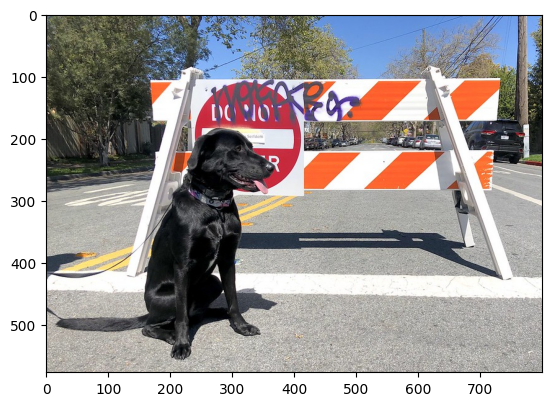

In [7]:
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print(f"The original shape of the image is {image.shape}")
print(f"The original data type of the image is {image.dtype}")

## Setup preprocessing steps with Preprocessing API and perform inference
[back to top ⬆️](#Table-of-contents:)

Intuitively, preprocessing API consists of the following parts:

- Tensor - declares user data format, like shape, layout, precision, color format from actual user's data.
- Steps - describes sequence of preprocessing steps which need to be applied to user data.
- Model - specifies model data format. Usually, precision and shape are already known for model, only additional information, like layout can be specified.

Graph modifications of a model shall be performed after the model is read from a drive and before it is loaded on the actual device.

Pre-processing support following operations (please, see more details [here](https://docs.openvino.ai/2024/api/c_cpp_api/group__ov__dev__exec__model.html#_CPPv3N2ov10preprocess15PreProcessStepsD0Ev))

- Mean/Scale Normalization
- Converting Precision
- Converting layout (transposing)
- Resizing Image
- Color Conversion
- Custom Operations

### Convert model to OpenVINO IR with model conversion API
[back to top ⬆️](#Table-of-contents:)

The options for preprocessing are not required.

In [8]:
ir_path = model_dir / "ir_model" / f"{model_name}.xml"

ppp_model = None

if ir_path.exists():
    ppp_model = core.read_model(model=ir_path)
    print(f"Model in OpenVINO format already exists: {ir_path}")
else:
    ppp_model = ov.convert_model(model_path, input=[1, 299, 299, 3])
    ov.save_model(ppp_model, str(ir_path))

Model in OpenVINO format already exists: model/ir_model/InceptionResNetV2.xml


### Create `PrePostProcessor` Object
[back to top ⬆️](#Table-of-contents:)

The [`PrePostProcessor()`](https://docs.openvino.ai/2024/api/c_cpp_api/classov_1_1preprocess_1_1_pre_post_processor.html) class enables specifying the preprocessing and postprocessing steps for a model.

In [9]:
from openvino.preprocess import PrePostProcessor

ppp = PrePostProcessor(ppp_model)

### Declare User’s Data Format
[back to top ⬆️](#Table-of-contents:)

To address particular input of a model/preprocessor, use the `PrePostProcessor.input(input_name)` method. If the model has only one input, then simple `PrePostProcessor.input()` will get a reference to pre-processing builder for this input (a tensor, the steps, a model). In general, when a model has multiple inputs/outputs, each one can be addressed by a tensor name or by its index.
By default, information about user’s input tensor will be initialized to same data (type/shape/etc) as model’s input parameter. User application can override particular parameters according to application’s data. Refer to the following [page](https://docs.openvino.ai/2024/api/c_cpp_api/group__ov__dev__exec__model.html#_CPPv3N2ov10preprocess9InputInfo6tensorEv) for more information about parameters for overriding.

Below is all the specified input information:

- Precision is `U8` (unsigned 8-bit integer).
- Size is non-fixed, setup of one determined shape size can be done with `.set_shape([1, 577, 800, 3])`
- Layout is `“NHWC”`. It means, for example: height=577, width=800, channels=3.

The height and width are necessary for resizing, and channels are needed for mean/scale normalization.

In [10]:
# setup formant of data
ppp.input().tensor().set_element_type(ov.Type.u8).set_spatial_dynamic_shape().set_layout(ov.Layout("NHWC"))

### Declaring Model Layout
[back to top ⬆️](#Table-of-contents:)

Model input already has information about precision and shape. Preprocessing API is not intended to modify this. The only thing that may be specified is input data [layout](https://docs.openvino.ai/2024/openvino-workflow/running-inference/optimize-inference/optimize-preprocessing/layout-api-overview.html).

In [11]:
input_layer_ir = next(iter(ppp_model.inputs))
print(f"The input shape of the model is {input_layer_ir.shape}")

ppp.input().model().set_layout(ov.Layout("NHWC"))

The input shape of the model is [1,299,299,3]


### Preprocessing Steps
[back to top ⬆️](#Table-of-contents:)

Now, the sequence of preprocessing steps can be defined. For more information about preprocessing steps, see [here](https://docs.openvino.ai/2024/api/ie_python_api/_autosummary/openvino.preprocess.PreProcessSteps.html).

Perform the following:

- Convert `U8` to `FP32` precision.
- Resize to height/width of a model. Be aware that if a model accepts dynamic size, for example, `{?, 3, ?, ?}` resize will not know how to resize the picture. Therefore, in this case, target height/ width should be specified. For more details, see also the [`PreProcessSteps.resize()`](https://docs.openvino.ai/2024/api/ie_python_api/_autosummary/openvino.preprocess.PreProcessSteps.html#openvino.preprocess.PreProcessSteps.resize).
- Subtract mean from each channel.
- Divide each pixel data to appropriate scale value.

There is no need to specify conversion layout. If layouts are different, then such conversion will be added explicitly.

In [12]:
from openvino.preprocess import ResizeAlgorithm

ppp.input().preprocess().convert_element_type(ov.Type.f32).resize(ResizeAlgorithm.RESIZE_LINEAR).mean([127.5, 127.5, 127.5]).scale([127.5, 127.5, 127.5])

### Integrating Steps into a Model
[back to top ⬆️](#Table-of-contents:)

Once the preprocessing steps have been finished, the model can be finally built. It is possible to display `PrePostProcessor` configuration for debugging purposes.

In [13]:
print(f"Dump preprocessor: {ppp}")
model_with_preprocess = ppp.build()

Dump preprocessor: Input "Func/StatefulPartitionedCall/input/_0:0":
    User's input tensor: [1,?,?,3], [N,H,W,C], u8
    Model's expected tensor: [1,299,299,3], [N,H,W,C], f32
    Pre-processing steps (4):
      convert type (f32): ([1,?,?,3], [N,H,W,C], u8) -> ([1,?,?,3], [N,H,W,C], f32)
      resize to model width/height: ([1,?,?,3], [N,H,W,C], f32) -> ([1,299,299,3], [N,H,W,C], f32)
      mean (127.5,127.5,127.5): ([1,299,299,3], [N,H,W,C], f32) -> ([1,299,299,3], [N,H,W,C], f32)
      scale (127.5,127.5,127.5): ([1,299,299,3], [N,H,W,C], f32) -> ([1,299,299,3], [N,H,W,C], f32)



## Load model and perform inference
[back to top ⬆️](#Table-of-contents:)


In [14]:
def prepare_image_api_preprocess(image_path, model=None):
    image = cv2.imread(image_path)
    input_tensor = np.expand_dims(image, 0)
    return input_tensor


compiled_model_with_preprocess_api = core.compile_model(model=ppp_model, device_name=device.value)

ppp_output_layer = compiled_model_with_preprocess_api.output(0)

ppp_input_tensor = prepare_image_api_preprocess(image_path)
results = compiled_model_with_preprocess_api(ppp_input_tensor)[ppp_output_layer][0]

## Fit image manually and perform inference
[back to top ⬆️](#Table-of-contents:)


### Load the model
[back to top ⬆️](#Table-of-contents:)


In [15]:
model = core.read_model(model=ir_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

### Load image and fit it to model input
[back to top ⬆️](#Table-of-contents:)


In [16]:
def manual_image_preprocessing(path_to_image, compiled_model):
    input_layer_ir = next(iter(compiled_model.inputs))

    # N, H, W, C = batch size, height, width, number of channels
    N, H, W, C = input_layer_ir.shape

    # load  image, image will be resized to model input size and converted to RGB
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(H, W), color_mode="rgb")

    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # will scale input pixels between -1 and 1
    input_tensor = tf.keras.applications.inception_resnet_v2.preprocess_input(x)

    return input_tensor


input_tensor = manual_image_preprocessing(image_path, compiled_model)
print(f"The shape of the image is {input_tensor.shape}")
print(f"The data type of the image is {input_tensor.dtype}")

The shape of the image is (1, 299, 299, 3)
The data type of the image is float32


### Perform inference
[back to top ⬆️](#Table-of-contents:)


In [17]:
output_layer = compiled_model.output(0)

result = compiled_model(input_tensor)[output_layer]

## Compare results
[back to top ⬆️](#Table-of-contents:)


### Compare results on one image
[back to top ⬆️](#Table-of-contents:)


In [18]:
def check_results(input_tensor, compiled_model, imagenet_classes):
    output_layer = compiled_model.output(0)

    results = compiled_model(input_tensor)[output_layer][0]

    top_indices = np.argsort(results)[-5:][::-1]
    top_softmax = results[top_indices]

    for index, softmax_probability in zip(top_indices, top_softmax):
        print(f"{imagenet_classes[index]}, {softmax_probability:.5f}")

    return top_indices, top_softmax


# Convert the inference result to a class name.
imagenet_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt",
    directory="data",
)
imagenet_classes = imagenet_filename.read_text().splitlines()
imagenet_classes = ["background"] + imagenet_classes

# get result for inference with preprocessing api
print("Result of inference with Preprocessing API:")
res = check_results(ppp_input_tensor, compiled_model_with_preprocess_api, imagenet_classes)

print("\n")

# get result for inference with the manual preparing of the image
print("Result of inference with manual image setup:")
res = check_results(input_tensor, compiled_model, imagenet_classes)

Result of inference with Preprocessing API:
n02099601 golden retriever, 0.80578
n02098413 Lhasa, Lhasa apso, 0.09990
n02108915 French bulldog, 0.01920
n02111129 Leonberg, 0.00829
n02097047 miniature schnauzer, 0.00294


Result of inference with manual image setup:
n02098413 Lhasa, Lhasa apso, 0.76843
n02099601 golden retriever, 0.19322
n02111129 Leonberg, 0.00720
n02097047 miniature schnauzer, 0.00287
n02100877 Irish setter, red setter, 0.00115


### Compare performance
[back to top ⬆️](#Table-of-contents:)


In [19]:
def check_performance(compiled_model, preprocessing_function=None):
    num_images = 1000

    start = time.perf_counter()

    for _ in range(num_images):
        input_tensor = preprocessing_function(image_path, compiled_model)
        compiled_model(input_tensor)

    end = time.perf_counter()
    time_ir = end - start

    return time_ir, num_images


time_ir, num_images = check_performance(compiled_model, manual_image_preprocessing)
print(f"IR model in OpenVINO Runtime/CPU with manual image preprocessing: {time_ir/num_images:.4f} " f"seconds per image, FPS: {num_images/time_ir:.2f}")

time_ir, num_images = check_performance(compiled_model_with_preprocess_api, prepare_image_api_preprocess)
print(f"IR model in OpenVINO Runtime/CPU with preprocessing API: {time_ir/num_images:.4f} " f"seconds per image, FPS: {num_images/time_ir:.2f}")

IR model in OpenVINO Runtime/CPU with manual image preprocessing: 0.0162 seconds per image, FPS: 61.85
IR model in OpenVINO Runtime/CPU with preprocessing API: 0.0204 seconds per image, FPS: 48.97
